In [72]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
current_pwd = os.getcwd()

possible_paths = [
    '/home/export/soheuny/SRFinder/soheun/notebooks', 
    '/home/soheuny/HH4bsim/soheun/notebooks'
]
    
assert os.getcwd() in possible_paths, f"Did you change the path? It should be one of {possible_paths}"
os.chdir("..")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch

from plots import hist_events_by_labels
from events_data import EventsData
from fvt_classifier import FvTClassifier
from tst_info import TSTInfo
# import LogNorm
from matplotlib.colors import LogNorm


features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


AssertionError: Did you change the path? It should be one of ['/home/export/soheuny/SRFinder/soheun/notebooks', '/home/soheuny/HH4bsim/soheun/notebooks']

In [ ]:
from events_data import events_from_scdinfo
from tst_info import TSTInfo
from debiasing import get_bias_fn, get_histograms
from plots import hist_events_by_labels
import tqdm
from matplotlib.colors import LogNorm
from dataset import generate_mother_dataset, split_scdinfo
import pytorch_lightning as pl
from signal_region import get_SR_stats
import itertools


In [73]:
from itertools import product
from training_info import TrainingInfoV2
from plots import calibration_plot, plot_rewighted_samples_by_model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from ancillary_features import get_m4j
from pl_callbacks import CalibrationPlotCallback, ReweightedPlotCallback

# use tex
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.titlesize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["figure.labelsize"] = 20
plt.rcParams["lines.markersize"] = 3

In [76]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd
import glob

experiment_name = "better_fvt_training"
signal_ratio = 0.0
hparams_filter = {
    "experiment_name": experiment_name,
    "signal_ratio": signal_ratio,
}
hashes, params = TrainingInfoV2.find(hparam_filter=hparams_filter, return_hparams=True)
tag = [p["train_seed"] - p["data_seed"] for p in params]
seeds = [p["seed"] for p in params]

log_dict_min_loss = []
log_dict_min_sigma_sq = []
log_dict = []
for hash_ in hashes:
    log_dir = f"tb_logs/{experiment_name}_{signal_ratio}/{hash_}/version_0/"
    glob_path = os.path.join(log_dir, "events.out.tfevents.*")
    glob_path = glob.glob(glob_path)
    assert len(glob_path) == 1, f"Found {len(glob_path)} > 1 log files"
    event_acc = event_accumulator.EventAccumulator(glob_path[0])
    event_acc.Reload()
    keys = event_acc.Tags()["scalars"]
    df_list = []
    
    for key in keys:
        if key == "hp_metric":
            continue
        events = event_acc.Scalars(key)
        index = [event.step for event in events]
        value = [event.value for event in events]
        df = pd.DataFrame({key: value}, index=index)
        if key == "epoch":
            df = df.drop_duplicates(subset=["epoch"])
        df_list.append(df)
    
    df = pd.concat(df_list, axis=1)
    df = df.reset_index(drop=True).set_index("epoch")
    
    # select row with smallest val_loss
    df_min_loss = df.loc[df["val_loss"].idxmin()]
    df_min_sigma_sq = df.loc[df["val_sigma_sq"].idxmin()]
    
    d_min_loss = df_min_loss.to_dict()
    d_min_sigma_sq = df_min_sigma_sq.to_dict()
    
    d_min_loss["hash"] = hash_
    d_min_sigma_sq["hash"] = hash_
    
    log_dict_min_loss.append(d_min_loss)
    log_dict_min_sigma_sq.append(d_min_sigma_sq)
    log_dict.append(df.to_dict())
    
df_min_loss = pd.DataFrame(log_dict_min_loss)
df_min_sigma_sq = pd.DataFrame(log_dict_min_sigma_sq)
df = pd.DataFrame(log_dict)

df_min_loss["tag"] = tag
df_min_loss["seed"] = seeds
df_min_sigma_sq["tag"] = tag
df_min_sigma_sq["seed"] = seeds

0.29
0.09


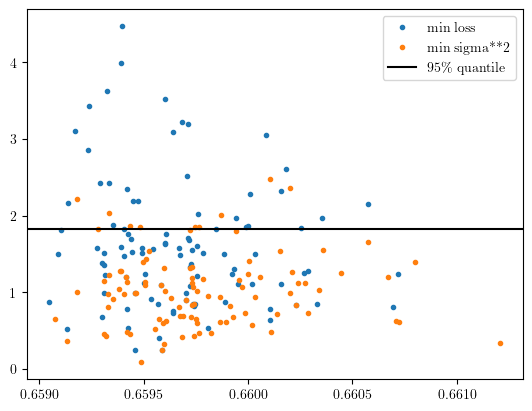

In [77]:
from scipy import stats

chi2_quantile = stats.chi2.ppf(0.95, df=10) / 10
print(np.mean(df_min_loss["val_sigma_sq"] > chi2_quantile))
print(np.mean(df_min_sigma_sq["val_sigma_sq"] > chi2_quantile))
plt.plot(df_min_loss["val_loss"], df_min_loss["val_sigma_sq"], 'o', label="min loss")
plt.plot(df_min_sigma_sq["val_loss"], df_min_sigma_sq["val_sigma_sq"], 'o', label="min sigma**2")
plt.axhline(chi2_quantile, color="k", label="95\% quantile")
plt.legend()
plt.show()


In [ ]:
plt.plot(df)

In [69]:
print(df_min_loss["val_loss"].mean())
print(df_min_sigma_sq["val_loss"].mean())

print(df_min_loss["val_sigma_sq"].mean())
print(df_min_sigma_sq["val_sigma_sq"].mean())


0.6585059320926666
0.6587552118301392
1.9339097607135773
1.3685468316078186


In [48]:
df_min_loss["seed"].value_counts()
# df_min_loss["tag"].value_counts()

seed
1     2
26    2
28    2
29    2
30    2
31    2
32    2
33    2
34    2
35    2
36    2
37    2
38    2
39    2
40    2
41    2
42    2
43    2
44    2
45    2
46    2
47    2
48    2
27    2
25    2
13    2
12    2
0     2
3     2
4     2
5     2
6     2
7     2
8     2
9     2
10    2
11    2
49    2
24    2
14    2
15    2
16    2
17    2
18    2
19    2
20    2
21    2
22    2
23    2
2     1
Name: count, dtype: int64

In [45]:
# calculate difference between val_sigma_sq of same seed but different tag
display(df_min_loss.groupby("seed")["val_sigma_sq"].std())
display(df_min_sigma_sq.groupby("seed")["val_sigma_sq"].std())


seed
0     0.281996
1     0.330821
2          NaN
3     0.310565
4     0.227323
5     0.342768
6     0.138248
7     0.813952
8     0.364782
9     0.135564
10    0.108893
11    0.366965
12    0.105080
13    0.286151
14    0.065340
15    0.465699
16    0.304635
17    0.155494
18    0.242574
19    0.013063
20    1.134716
21    0.404647
22    0.092697
23    0.210898
24    0.343776
25    0.223487
26    0.133070
27    0.526076
28    0.317807
29    0.190037
30    0.133578
31    0.039830
32    0.163210
33    0.396911
34    0.054166
35    0.419013
36    0.522673
37    0.056600
38    0.317933
39    0.089270
40    0.069468
41    0.083943
42    0.089407
43    0.000168
44    0.032435
45    1.409301
46    0.252662
47    0.168598
48    0.442006
49    0.287779
Name: val_sigma_sq, dtype: float64

seed
0     0.375567
1     0.416672
2          NaN
3     0.276243
4     0.097230
5     0.493415
6     0.147692
7     0.005986
8     0.309658
9     0.190223
10    0.051485
11    0.021750
12    0.005545
13    0.196548
14    0.164197
15    0.261191
16    0.016156
17    0.122498
18    0.008151
19    0.378833
20    0.700219
21    0.013248
22    0.072557
23    0.257350
24    0.393131
25    0.020504
26    0.322629
27    0.151274
28    0.323192
29    0.191370
30    0.087778
31    0.042020
32    0.185076
33    0.212120
34    0.084502
35    0.166538
36    0.078272
37    0.176730
38    0.086924
39    0.182263
40    0.114813
41    0.161501
42    0.053777
43    0.010504
44    0.040374
45    0.594087
46    0.203898
47    0.006904
48    0.146969
49    0.103689
Name: val_sigma_sq, dtype: float64

# Original FvT

In [16]:
import pathlib
import time

n_3b = 100_0000
device = torch.device("cuda")
experiment_name = "counting_test_v2"
signal_filename = "HH4b_picoAOD.h5"
ratio_4b = 0.5

seeds = [4]

hparam_filter = {
    "experiment_name": lambda x: x in [experiment_name],
    "n_3b": n_3b,
    "seed": lambda x: x in seeds,
    "signal_ratio": 0.02
}
hashes = TSTInfo.find(hparam_filter, sort_by=["seed", "signal_ratio"])

for tstinfo_hash in hashes:
    tstinfo = TSTInfo.load(tstinfo_hash)
    seed = tstinfo.hparams["seed"]
    print(f"n_3b={tstinfo.hparams['n_3b']}, signal_ratio={tstinfo.hparams['signal_ratio']}, seed={tstinfo.hparams['seed']}")
    base_fvt_tinfo_hash = tstinfo.base_fvt_tinfo_hash
    base_fvt_tinfo = TrainingInfoV2.load(base_fvt_tinfo_hash)
    
    train_scdinfo, val_scdinfo = base_fvt_tinfo.fetch_train_val_scdinfo()
    events_train = events_from_scdinfo(train_scdinfo, features, signal_filename)
    events_val = events_from_scdinfo(val_scdinfo, features, signal_filename)
    events_tst = events_from_scdinfo(tstinfo.scdinfo_tst, features, signal_filename)
    events_train.shuffle(seed=seed)
    events_val.shuffle(seed=seed)
    events_tst.shuffle(seed=seed)

    # batch_size = base_fvt_tinfo.hparams["batch_size"] # double the batch size to fit the kernel matrix
    batch_size = 2 ** 12
    
    events_train.fit_batch_size(batch_size)
    events_val.fit_batch_size(batch_size)
    timestamp = int(time.time())
    
    for variance_beta, calibration_h, variance_loss_on_train in [(0.0, 0.1, False)]:
        print("=" * 100)
        print(f"variance_beta={variance_beta}, calibration_h={calibration_h}, variance_loss_on_train={variance_loss_on_train}")
        base_model_new = FvTClassifier(
            num_classes=2,
            dim_input_jet_features=4, 
            dim_dijet_features=base_fvt_tinfo.hparams["dim_dijet_features"],
            dim_quadjet_features=base_fvt_tinfo.hparams["dim_quadjet_features"],
            run_name=f"variance_beta={variance_beta}_seed={seed}_timestamp={timestamp}",
            device=device,
            lr=1e-3,
            lr_reduce_patience=3
        )
        base_model_new.fit(
            events_train.to_tensor_dataset(),
            events_val.to_tensor_dataset(),
            batch_size=batch_size,
            max_epochs=50,
            train_seed=seed,
            save_checkpoint=False,
        )
        
        history = base_model_new.history
    
        checkpoint_path = pathlib.Path(
            f"./data/tmp/checkpoints/{base_model_new.run_name}_best.ckpt"
        )
        base_model_new = FvTClassifier.load_from_checkpoint(checkpoint_path)
        base_model_new.eval()
        base_model_new.to(device)
        
        q = np.linspace(0, 1, 11)
        
        preds = base_model_new.predict(events_train.X_torch.to(device))[:, 1].detach().cpu().numpy()
        cal_bins = np.quantile(preds, q)
        reweights = preds / (1 - preds) * (ratio_4b / (1 - ratio_4b))
        w_rw = np.where(events_train.is_4b, events_train.weights, 
                             -events_train.weights * reweights)
        w_rw_sq = np.where(events_train.is_4b, events_train.weights, events_train.weights * reweights**2)
        bin_idx = np.digitize(preds, bins=cal_bins)
        bin_idx = np.clip(bin_idx, 1, len(cal_bins) - 1) - 1
        bin_losses = []
        for i in range(len(cal_bins) - 1):
            mask = bin_idx == i
            bin_losses.append(np.sum(w_rw[mask])**2 / np.sum(w_rw_sq[mask]))
            print(np.sum(w_rw[mask]) / np.sqrt(np.sum(w_rw_sq[mask])))
        print("Train: ", np.mean(bin_losses))
        
        plot_rewighted_samples_by_model(base_model_new, events_train, bins=cal_bins, figsize=(10, 5), 
                                        title=f"seed={seed}, variance_beta={variance_beta}, nbins={int(1/calibration_h)}, variance_loss_on_train={variance_loss_on_train}, train", ratio_4b=ratio_4b)

        preds = base_model_new.predict(events_val.X_torch.to(device))[:, 1].detach().cpu().numpy()
        cal_bins = np.quantile(preds, q)
        reweights = preds / (1 - preds) * (ratio_4b / (1 - ratio_4b))
        w_rw = np.where(events_val.is_4b, events_val.weights, 
                             -events_val.weights * reweights)
        w_rw_sq = np.where(events_val.is_4b, events_val.weights, events_val.weights * reweights**2)
        bin_idx = np.digitize(preds, bins=cal_bins)
        bin_idx = np.clip(bin_idx, 1, len(cal_bins) - 1) - 1
        bin_losses = []
        for i in range(len(cal_bins) - 1):
            mask = bin_idx == i
            bin_losses.append(np.sum(w_rw[mask])**2 / np.sum(w_rw_sq[mask]))
            print(np.sum(w_rw[mask]) / np.sqrt(np.sum(w_rw_sq[mask])))
        print("Val: ", np.mean(bin_losses))
        
        plot_rewighted_samples_by_model(base_model_new, events_val, bins=cal_bins, figsize=(10, 5), 
                                        title=f"seed={seed}, variance_beta={variance_beta}, nbins={int(1/calibration_h)}, variance_loss_on_train={variance_loss_on_train}, val", ratio_4b=ratio_4b)
        
        preds = base_model_new.predict(events_tst.X_torch.to(device))[:, 1].detach().cpu().numpy()
        cal_bins = np.quantile(preds, q)
        reweights = preds / (1 - preds) * (ratio_4b / (1 - ratio_4b))
        w_rw = np.where(events_tst.is_4b, events_tst.weights, 
                             -events_tst.weights * reweights)
        w_rw_sq = np.where(events_tst.is_4b, events_tst.weights, events_tst.weights * reweights**2)
        bin_idx = np.digitize(preds, bins=cal_bins)
        bin_idx = np.clip(bin_idx, 1, len(cal_bins) - 1) - 1
        bin_losses = []
        for i in range(len(cal_bins) - 1):
            mask = bin_idx == i
            bin_losses.append(np.sum(w_rw[mask])**2 / np.sum(w_rw_sq[mask]))
            print(np.sum(w_rw[mask]) / np.sqrt(np.sum(w_rw_sq[mask])))
        print("All together: ", np.mean(bin_losses))
        
        plot_rewighted_samples_by_model(base_model_new, events_tst, bins=cal_bins, figsize=(10, 5), 
                                        title=f"seed={seed}, variance_beta={variance_beta}, nbins={int(1/calibration_h)}, variance_loss_on_train={variance_loss_on_train}, all together", ratio_4b=ratio_4b)
        
        val_history = [h for h in history if "val_loss" in h]
        plt.title("Validation")
        plt.plot([h["val_variance_loss"].item() for h in val_history], label="avg sigma**2")
        plt.ylabel("avg sigma**2")
        plt.xlabel("epoch")
        plt.ylim(0, 10)
        plt.legend(loc="upper left")
        twinx = plt.gca().twinx()
        twinx.plot([h["val_ce_loss"].item() for h in val_history], color="tab:orange", label="CE loss")
        twinx.plot([h["val_loss"].item() for h in val_history], color="tab:green", label="Val loss")
        twinx.set_ylabel("CE loss")
        plt.yscale("log")
        plt.ylim(0.65, 0.67)
        plt.legend(loc="upper right")
        plt.show()
        plt.close()

        train_history = [h for h in history if "train_loss" in h]
        plt.title("Training")
        plt.plot([h["train_variance_loss"].item() for h in train_history], label="avg sigma**2")
        plt.ylabel("avg sigma**2")
        plt.xlabel("epoch")
        plt.ylim(0, 10)
        plt.legend(loc="upper left")
        twinx = plt.gca().twinx()
        twinx.plot([h["train_ce_loss"].item() for h in train_history], color="tab:orange", label="CE loss")
        twinx.plot([h["train_loss"].item() for h in train_history], color="tab:green", label="Val loss")
        twinx.set_ylabel("CE loss")
        plt.yscale("log")
        plt.ylim(0.65, 0.67)
        plt.legend(loc="upper right")
        plt.show()
        plt.close()

n_3b=1000000, signal_ratio=0.02, seed=4


[rank: 0] Seed set to 4
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

variance_beta=0.0, calibration_h=0.1, variance_loss_on_train=False
Epoch 9:   0%|          | 0/256 [00:00<?, ?it/s, v_num=0, 1000x_val_loss_first_digits=659.0, 1000x_val_loss_second_digits=0.289, val_variance_loss=5.570, last_lr=0.001, train_loss_lower_digits=660.0, train_loss_second_digits=0.521, train_variance_loss=444.0]           

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f47eb99cc20>
Traceback (most recent call last):
  File "/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/multiprocessing/connection.py", line 948, in wai

Epoch 9:  29%|██▉       | 75/256 [00:21<00:51,  3.50it/s, v_num=0, 1000x_val_loss_first_digits=659.0, 1000x_val_loss_second_digits=0.289, val_variance_loss=5.570, last_lr=0.001, train_loss_lower_digits=660.0, train_loss_second_digits=0.429, train_variance_loss=448.0]

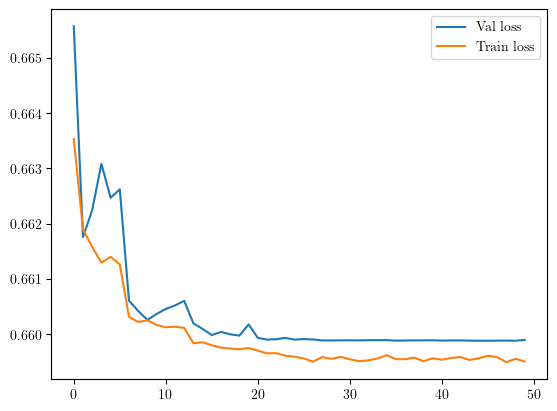

In [8]:
val_history = [h for h in history if "val_loss" in h]
train_history = [h for h in history if "train_loss" in h]
plt.plot([h["val_loss"].item() for h in val_history], label="Val loss")
plt.plot([h["train_loss"].item() for h in train_history], label="Train loss")
plt.legend()
plt.show()
plt.close()


n_3b=1000000, signal_ratio=0.0, seed=4


[rank: 0] Seed set to 4
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

variance_beta=0.0, calibration_h=0.1, variance_loss_on_train=False
Epoch 49: 100%|██████████| 290/290 [00:10<00:00, 27.30it/s, v_num=0, 1000x_val_loss_first_digits=679.0, 1000x_val_loss_second_digits=0.438, val_variance_loss=4.440, last_lr=5e-5, train_loss_lower_digits=679.0, train_loss_second_digits=0.750, train_variance_loss=1.050]    

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 290/290 [00:10<00:00, 27.27it/s, v_num=0, 1000x_val_loss_first_digits=679.0, 1000x_val_loss_second_digits=0.438, val_variance_loss=4.440, last_lr=5e-5, train_loss_lower_digits=679.0, train_loss_second_digits=0.750, train_variance_loss=1.050]
-0.08041666
-1.2218387
-0.2396099
1.2971697
-1.2891763
1.0985184
0.7053058
-0.3735329
0.50935185
-3.5151227
Train:  1.9360647968221911
[-0.08051782 -1.2220445  -0.23947014  1.2972101  -1.289105    1.0984031
  0.7053026  -0.37416497  0.5093315  -3.5146089 ]


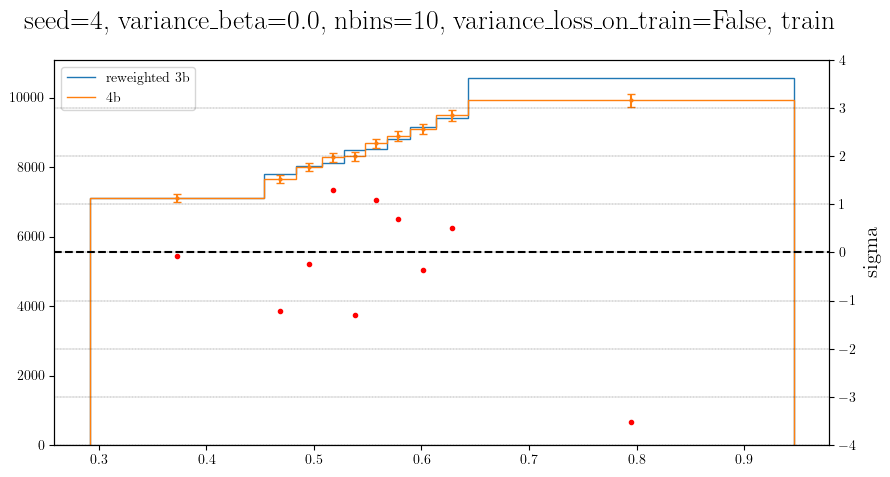

0.9522752
0.7462288
0.7080553
1.7095407
0.92947656
0.31021026
3.1885056
1.3410325
0.4974032
-4.202802
Val:  3.5723607500037162
[ 0.95228046  0.7460786   0.70810837  1.7093846   0.9291263   0.31096402
  3.189513    1.3405124   0.49823427 -4.2034106 ]


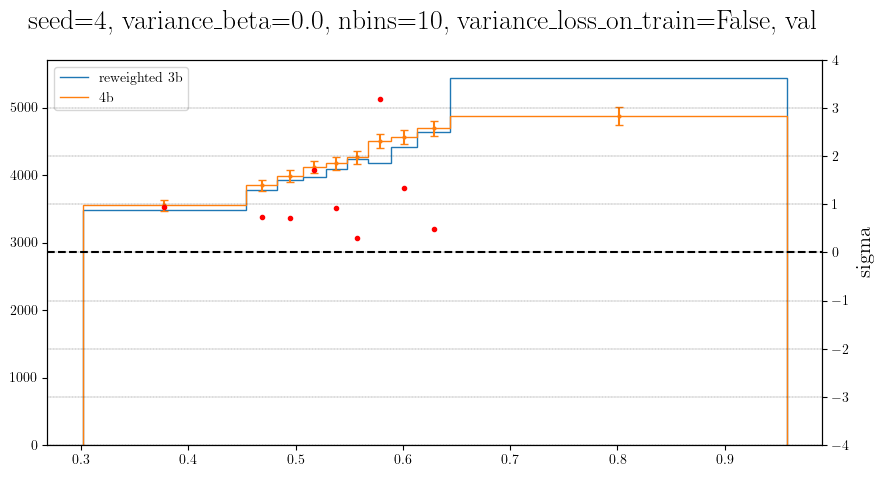

0.94114655
-0.024869168
0.6929882
2.5405824
-0.22698054
1.3335212
2.7316992
0.7697984
0.8525445
-5.129882
All together:  4.474825732833622
[ 0.94113773 -0.02490899  0.69309735  2.5404491  -0.227018    1.3332311
  2.7320468   0.7702557   0.8527005  -5.129385  ]


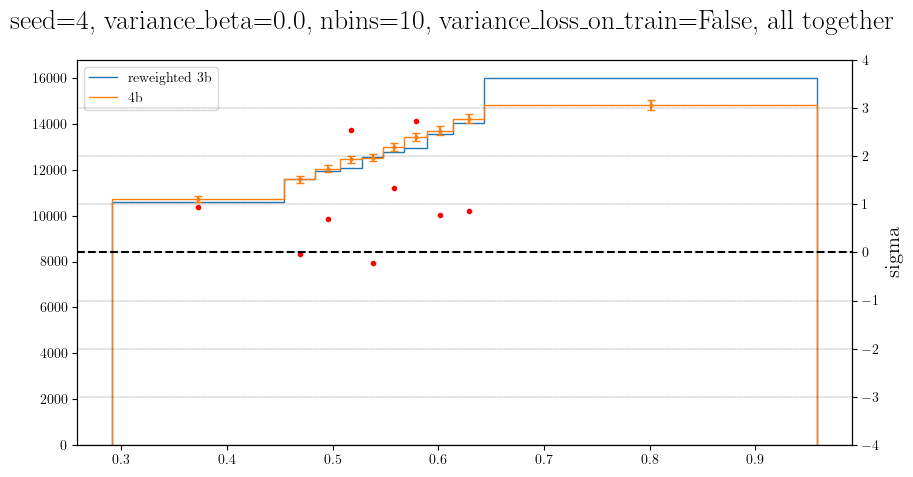

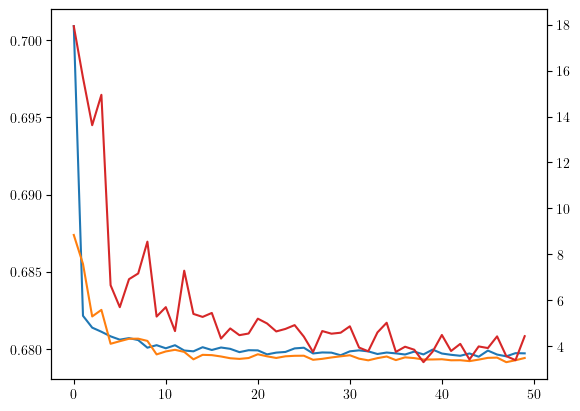

In [14]:
import pathlib
import time

n_3b = 100_0000
device = torch.device("cuda")
experiment_name = "counting_test_v2"
signal_filename = "HH4b_picoAOD.h5"
ratio_4b = 0.5

seeds = [4]

hparam_filter = {
    "experiment_name": lambda x: x in [experiment_name],
    "n_3b": n_3b,
    "seed": lambda x: x in seeds,
    "signal_ratio": 0.0
}
hashes = TSTInfo.find(hparam_filter, sort_by=["seed", "signal_ratio"])

for tstinfo_hash in hashes:
    tstinfo = TSTInfo.load(tstinfo_hash)
    seed = tstinfo.hparams["seed"]
    print(f"n_3b={tstinfo.hparams['n_3b']}, signal_ratio={tstinfo.hparams['signal_ratio']}, seed={tstinfo.hparams['seed']}")
    CR_fvt_tinfo_hash = tstinfo.CR_fvt_tinfo_hash
    CR_fvt_tinfo = TrainingInfoV2.load(CR_fvt_tinfo_hash)
    
    train_scdinfo, val_scdinfo = CR_fvt_tinfo.fetch_train_val_scdinfo()
    events_train = events_from_scdinfo(train_scdinfo, features, signal_filename)
    events_val = events_from_scdinfo(val_scdinfo, features, signal_filename)
    events_tst = events_from_scdinfo(tstinfo.scdinfo_tst, features, signal_filename)

    # batch_size = CR_fvt_tinfo.hparams["batch_size"] # double the batch size to fit the kernel matrix
    batch_size = 2 ** 9
    SR_stat = tstinfo.SR_stats
    SR_cut = tstinfo.SR_cut
    CR_cut = tstinfo.CR_cut
    in_CR = (SR_stat >= CR_cut) & (SR_stat < SR_cut)
    events_tst_CR = events_tst[in_CR]

    events_train.fit_batch_size(batch_size)
    events_val.fit_batch_size(batch_size)
    
    events_train.shuffle(seed=seed)
    events_val.shuffle(seed=seed)
    events_tst_CR.shuffle(seed=seed)
    
    # get timestamp
    
    timestamp = int(time.time())
    
    # for variance_beta, calibration_h, variance_loss_on_train in product(
    #     [1e-3], [0.1, 0.25, 1.0], [False, True]):
    for variance_beta, calibration_h, variance_loss_on_train in [(0.0, 0.1, False)]:
        print("=" * 100)
        print(f"variance_beta={variance_beta}, calibration_h={calibration_h}, variance_loss_on_train={variance_loss_on_train}")
        CR_model_new = FvTClassifier(
            num_classes=2,
            dim_input_jet_features=4, 
            dim_dijet_features=CR_fvt_tinfo.hparams["dim_dijet_features"],
            dim_quadjet_features=CR_fvt_tinfo.hparams["dim_quadjet_features"],
            run_name=f"variance_beta={variance_beta}_seed={seed}_timestamp={timestamp}",
            device=device,
            lr=1e-3,
            variance_beta=variance_beta,
            calibration_h=calibration_h,
            variance_loss_on_train=variance_loss_on_train,
            lr_reduce_patience=3,
            early_stop_patience=50,
        )
        CR_model_new.fit(
            events_train.to_tensor_dataset(),
            events_val.to_tensor_dataset(),
            batch_size=batch_size,
            max_epochs=50,
            train_seed=seed,
            save_checkpoint=False,
        )
        
        history = CR_model_new.history
    
        checkpoint_path = pathlib.Path(
            f"./data/tmp/checkpoints/{CR_model_new.run_name}_best.ckpt"
        )
        CR_model_new = FvTClassifier.load_from_checkpoint(checkpoint_path)
        CR_model_new.eval()
        CR_model_new.to(device)
        
        q = np.linspace(0, 1, 11)
        
        preds = CR_model_new.predict(events_train.X_torch.to(device))[:, 1].detach().cpu().numpy()
        cal_bins = np.quantile(preds, q)
        reweights = preds / (1 - preds) * (ratio_4b / (1 - ratio_4b))
        w_rw = np.where(events_train.is_4b, events_train.weights, 
                             -events_train.weights * reweights)
        w_rw_sq = np.where(events_train.is_4b, events_train.weights, events_train.weights * reweights**2)
        bin_idx = np.digitize(preds, bins=cal_bins)
        bin_idx = np.clip(bin_idx, 1, len(cal_bins) - 1) - 1
        bin_losses = []
        for i in range(len(cal_bins) - 1):
            mask = bin_idx == i
            bin_losses.append(np.sum(w_rw[mask])**2 / np.sum(w_rw_sq[mask]))
            print(np.sum(w_rw[mask]) / np.sqrt(np.sum(w_rw_sq[mask])))
        print("Train: ", np.mean(bin_losses))
        
        plot_rewighted_samples_by_model(CR_model_new, events_train, bins=cal_bins, figsize=(10, 5), 
                                        title=f"seed={seed}, variance_beta={variance_beta}, nbins={int(1/calibration_h)}, variance_loss_on_train={variance_loss_on_train}, train", ratio_4b=ratio_4b)

        preds = CR_model_new.predict(events_val.X_torch.to(device))[:, 1].detach().cpu().numpy()
        cal_bins = np.quantile(preds, q)
        reweights = preds / (1 - preds) * (ratio_4b / (1 - ratio_4b))
        w_rw = np.where(events_val.is_4b, events_val.weights, 
                             -events_val.weights * reweights)
        w_rw_sq = np.where(events_val.is_4b, events_val.weights, events_val.weights * reweights**2)
        bin_idx = np.digitize(preds, bins=cal_bins)
        bin_idx = np.clip(bin_idx, 1, len(cal_bins) - 1) - 1
        bin_losses = []
        for i in range(len(cal_bins) - 1):
            mask = bin_idx == i
            bin_losses.append(np.sum(w_rw[mask])**2 / np.sum(w_rw_sq[mask]))
            print(np.sum(w_rw[mask]) / np.sqrt(np.sum(w_rw_sq[mask])))
        print("Val: ", np.mean(bin_losses))
        
        plot_rewighted_samples_by_model(CR_model_new, events_val, bins=cal_bins, figsize=(10, 5), 
                                        title=f"seed={seed}, variance_beta={variance_beta}, nbins={int(1/calibration_h)}, variance_loss_on_train={variance_loss_on_train}, val", ratio_4b=ratio_4b)
        
        preds = CR_model_new.predict(events_tst_CR.X_torch.to(device))[:, 1].detach().cpu().numpy()
        cal_bins = np.quantile(preds, q)
        reweights = preds / (1 - preds) * (ratio_4b / (1 - ratio_4b))
        w_rw = np.where(events_tst_CR.is_4b, events_tst_CR.weights, 
                             -events_tst_CR.weights * reweights)
        w_rw_sq = np.where(events_tst_CR.is_4b, events_tst_CR.weights, events_tst_CR.weights * reweights**2)
        bin_idx = np.digitize(preds, bins=cal_bins)
        bin_idx = np.clip(bin_idx, 1, len(cal_bins) - 1) - 1
        bin_losses = []
        for i in range(len(cal_bins) - 1):
            mask = bin_idx == i
            bin_losses.append(np.sum(w_rw[mask])**2 / np.sum(w_rw_sq[mask]))
            print(np.sum(w_rw[mask]) / np.sqrt(np.sum(w_rw_sq[mask])))
        print("All together: ", np.mean(bin_losses))
        
        plot_rewighted_samples_by_model(CR_model_new, events_tst_CR, bins=cal_bins, figsize=(10, 5), 
                                        title=f"seed={seed}, variance_beta={variance_beta}, nbins={int(1/calibration_h)}, variance_loss_on_train={variance_loss_on_train}, all together", ratio_4b=ratio_4b)
        
        plt.plot([h["train_loss"].item() for h in history], label="train loss")
        plt.plot([h["val_loss"].item() for h in history], label="val loss")
        twinx = plt.gca().twinx()
        twinx.plot([h["val_variance_loss"].item() for h in history], label="avg sigma**2", color="tab:red")
        plt.show()
        plt.close()

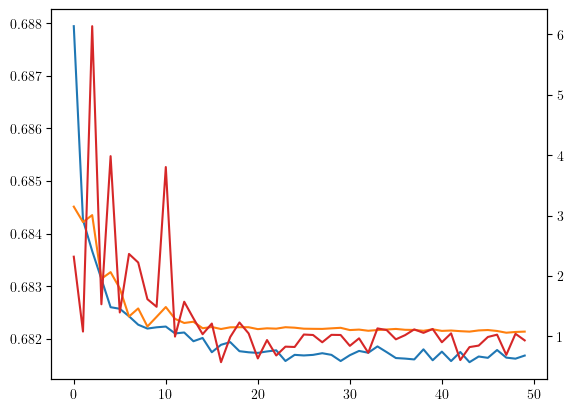

In [13]:
plt.plot([h["train_loss"].item() for h in val_history], label="train loss")
plt.plot([h["val_loss"].item() for h in val_history], label="val loss")
twinx = plt.gca().twinx()
twinx.plot([h["val_variance_loss"].item() for h in val_history], label="avg sigma**2", color="tab:red")
plt.show()
plt.close()

In [1]:
CR_model_new.to(device)
CR_model_new.eval()

q = np.linspace(0, 1, 11)
        
CR_model_new.load_tmp_checkpoint()
preds = CR_model_new.predict(events_train.X_torch.to(device))[:, 1].detach().cpu().numpy()
reweights = preds / (1 - preds) * (ratio_4b / (1 - ratio_4b))
reweights = np.where(events_train.is_4b, events_train.weights, -events_train.weights * reweights)
print("Train: ", np.mean(reweights)**2)
cal_bins = np.quantile(preds, q)
plot_rewighted_samples_by_model(CR_model_new, events_train, bins=cal_bins, figsize=(10, 5), 
                                title=f"seed={seed}, variance_beta={variance_beta}, train", ratio_4b=ratio_4b)

preds = CR_model_new.predict(events_val.X_torch.to(device))[:, 1].detach().cpu().numpy()
reweights = preds / (1 - preds) * (ratio_4b / (1 - ratio_4b))
reweights = np.where(events_val.is_4b, events_val.weights, -events_val.weights * reweights)
print("Val: ", np.mean(reweights)**2)
cal_bins = np.quantile(preds, q)
plot_rewighted_samples_by_model(CR_model_new, events_val, bins=cal_bins, figsize=(10, 5), 
                                title=f"seed={seed}, variance_beta={variance_beta}, val", ratio_4b=ratio_4b)

preds = CR_model_new.predict(events_tst_CR.X_torch.to(device))[:, 1].detach().cpu().numpy()
reweights = preds / (1 - preds) * (ratio_4b / (1 - ratio_4b))
reweights = np.where(events_tst_CR.is_4b, events_tst_CR.weights, -events_tst_CR.weights * reweights)
print("All together: ", np.mean(reweights)**2)
cal_bins = np.quantile(preds, q)
plot_rewighted_samples_by_model(CR_model_new, events_tst_CR, bins=cal_bins, figsize=(10, 5), 
                                title=f"seed={seed}, variance_beta={variance_beta}, all together", ratio_4b=ratio_4b)

NameError: name 'CR_model_new' is not defined

In [17]:
variance_losses = []
CR_model_new.eval()
CR_model_new.to(device)
print()

for _ in tqdm.tqdm(range(100)):
    random_idx = np.random.choice(len(events_val), size=2**10, replace=True)
    random_events = events_val[random_idx]
    variance_losses.append(CR_model_new.variance_loss(CR_model_new(random_events.X_torch.to(device)), 
                                                      random_events.is_4b_torch.to(device), 
                                                      random_events.weights_torch.to(device)).detach().cpu().numpy())
print(np.mean(variance_losses))
preds = CR_model_new.predict(events_val.X_torch.to(device))[:, 1].detach().cpu().numpy()
reweights = preds / (1 - preds) * (ratio_4b / (1 - ratio_4b))
reweights = np.where(events_val.is_4b, events_val.weights, -events_val.weights * reweights)
print((np.mean(reweights)) ** 2)
print(np.std(variance_losses))

100%|██████████| 100/100 [00:08<00:00, 11.11it/s]

0.00043549965
1.1370093949368e-05
0.004623593


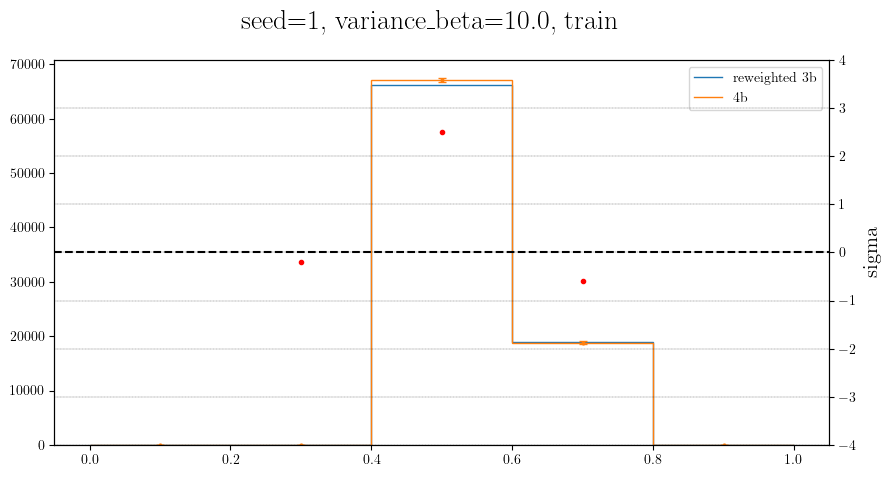

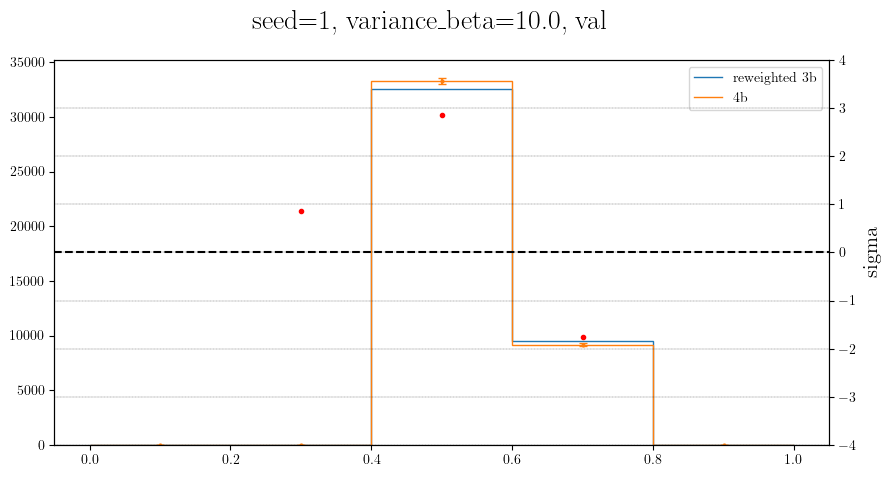

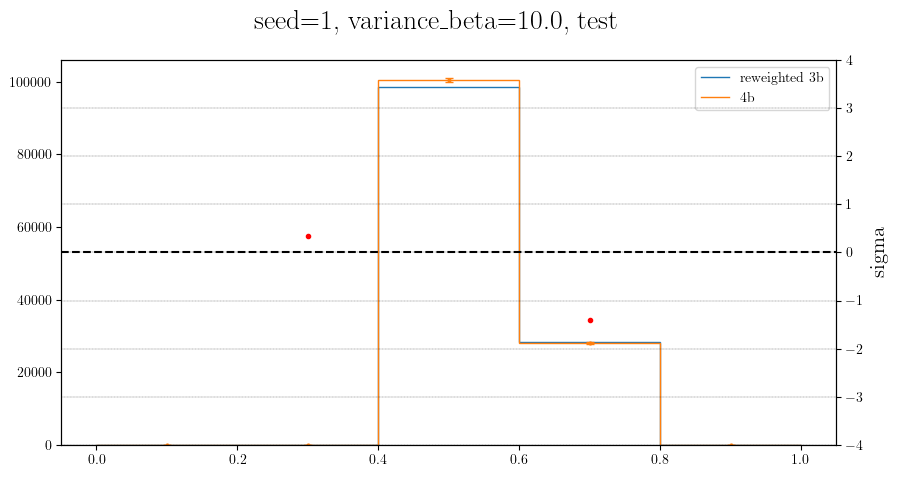

In [23]:
nbins = int(1 / CR_model_new.calibration_h)
plot_rewighted_samples_by_model(CR_model_new, events_train, bins=np.linspace(0, 1, nbins + 1), figsize=(10, 5), 
                                        title=f"seed={seed}, variance_beta={variance_beta}, train", ratio_4b=ratio_4b)
plot_rewighted_samples_by_model(CR_model_new, events_val, bins=np.linspace(0, 1, nbins + 1), figsize=(10, 5), 
                                title=f"seed={seed}, variance_beta={variance_beta}, val", ratio_4b=ratio_4b)
plot_rewighted_samples_by_model(CR_model_new, events_tst_CR, bins=np.linspace(0, 1, nbins + 1), figsize=(10, 5), 
                                title=f"seed={seed}, variance_beta={variance_beta}, test", ratio_4b=ratio_4b)

n_3b=1000000, signal_ratio=0.0, seed=4


[rank: 0] Seed set to 4
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 20.7 K
1 | select_q | conv1d     | 34    
2 | out      | conv1d     | 68    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.0, kernel=bins_best.ckpt


/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 11: 100%|██████████| 36/36 [00:04<00:00,  8.12it/s, v_num=3, val_loss=0.678, val_ce_loss=0.678, val_cal_loss=0.0129, train_loss=0.678, train_ce_loss=0.678, train_cal_loss=0.0155]


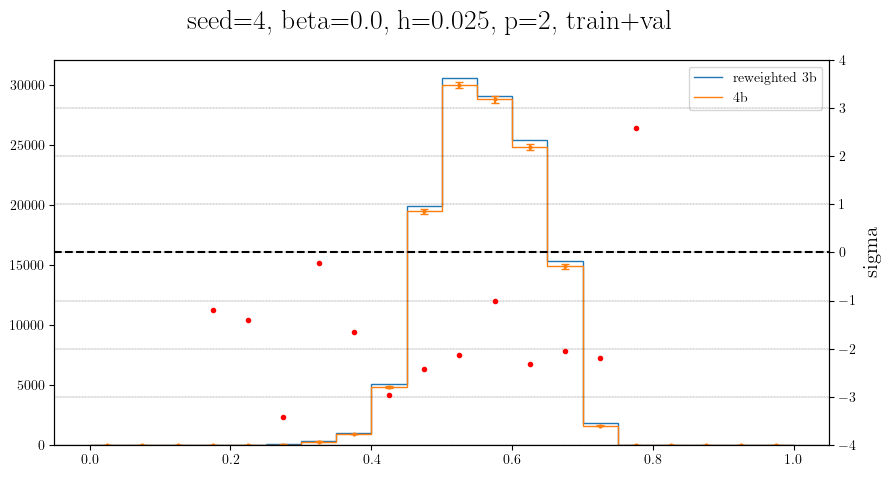

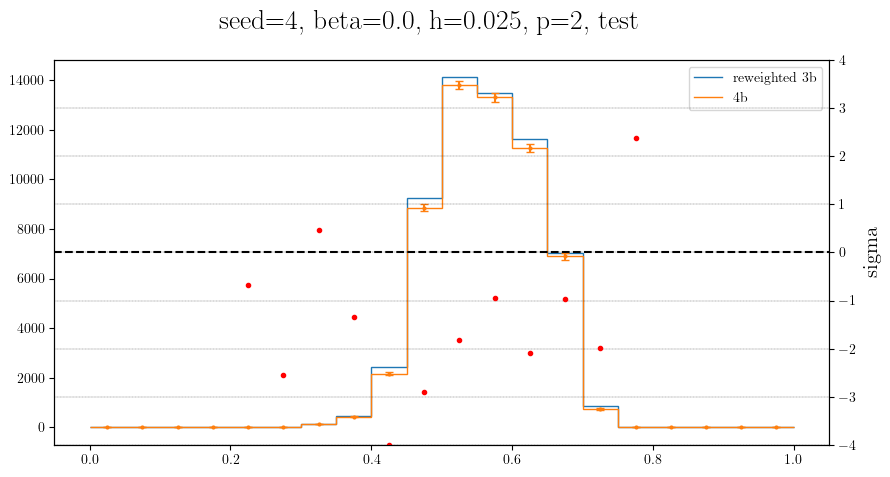

In [12]:
from itertools import product
from training_info import TrainingInfoV2
from plots import calibration_plot, plot_rewighted_samples_by_model, plot_rewighted_samples_by_model_v2
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from ancillary_features import get_m4j
from pl_callbacks import CalibrationPlotCallback, ReweightedPlotCallback

# use tex
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.titlesize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["figure.labelsize"] = 20

n_3b = 100_0000
device = torch.device("cuda")
experiment_name = "counting_test_v2"
signal_filename = "HH4b_picoAOD.h5"
ratio_4b = 0.5
cal_bins = np.linspace(0, 1, 21)
seeds = [4]

hparam_filter = {
    "experiment_name": lambda x: x in [experiment_name],

    "n_3b": n_3b,
    "seed": lambda x: x in seeds,
    "signal_ratio": 0.0
}
hashes = TSTInfo.find(hparam_filter, sort_by=["seed", "signal_ratio"])

for tstinfo_hash in hashes:
    tstinfo = TSTInfo.load(tstinfo_hash)
    seed = tstinfo.hparams["seed"]
    print(f"n_3b={tstinfo.hparams['n_3b']}, signal_ratio={tstinfo.hparams['signal_ratio']}, seed={tstinfo.hparams['seed']}")
    CR_fvt_tinfo_hash = tstinfo.CR_fvt_tinfo_hash
    CR_fvt_tinfo = TrainingInfoV2.load(CR_fvt_tinfo_hash)
    CR_model = FvTClassifier.load_from_checkpoint(f"data/checkpoints/{CR_fvt_tinfo.hash}_best.ckpt")
    CR_model.to(device)
    CR_model.eval()
    
    train_scdinfo, val_scdinfo = CR_fvt_tinfo.fetch_train_val_scdinfo()
    events_train = events_from_scdinfo(train_scdinfo, features, signal_filename)
    events_val = events_from_scdinfo(val_scdinfo, features, signal_filename)
    events_tst = events_from_scdinfo(tstinfo.scdinfo_tst, features, signal_filename)


    # batch_size = CR_fvt_tinfo.hparams["batch_size"] # double the batch size to fit the kernel matrix
    batch_size = 2 ** 12
    SR_stat = tstinfo.SR_stats
    SR_cut = tstinfo.SR_cut
    CR_cut = tstinfo.CR_cut
    in_CR = (SR_stat >= CR_cut) & (SR_stat < SR_cut)
    events_tst_CR = events_tst[in_CR]

    # shuffle events_val to calculate calibration loss
    events_train.shuffle(seed=seed)
    events_val.shuffle(seed=seed)
    events_tst_CR.shuffle(seed=seed)
    
    events_train.fit_batch_size(batch_size)
    events_val.fit_batch_size(batch_size)
    events_tst_CR = events_tst_CR[:100_000]
    
    cheating_beta = 0.0
    cheating_h = 0.1
    

    for calib_beta ,calib_h, calib_p, calib_kernel_type in list(product([0.0], [0.025], [2], ["bins"])):
        CR_model_new = FvTClassifier(
            num_classes=2,
            dim_input_jet_features=4, 
            dim_dijet_features=32,
            dim_quadjet_features=32,
            run_name=f"beta={calib_beta}, kernel={calib_kernel_type}",
            device=device,
            lr=0.001,
            calibration_h=calib_h,
            calibration_beta=calib_beta,
            cheating_beta=cheating_beta,
            cheating_h=cheating_h
        )
        CR_model_new.fit(
            events_train.to_tensor_dataset(),
            events_val.to_tensor_dataset(),
            batch_size=batch_size,
            max_epochs=50,
            train_seed=seed,
            save_checkpoint=False,
            callbacks=[
                # ReweightedPlotCallback(events_train, bins=cal_bins, figsize=(10, 5), title=f"beta={calib_beta}, train", 
                #                        plot_every_n_epochs=10, ratio_4b=ratio_4b),
                # ReweightedPlotCallback(events_val, bins=cal_bins, figsize=(10, 5), title=f"beta={calib_beta}, val", 
                #                        plot_every_n_epochs=10, ratio_4b=ratio_4b),
                # ReweightedPlotCallback(events_tst_CR, bins=cal_bins, figsize=(10, 5), title=f"beta={calib_beta}, test", 
                #                        plot_every_n_epochs=10, ratio_4b=ratio_4b),
                ]
        )
        
        CR_model_new.load_tmp_checkpoint()
        plot_rewighted_samples_by_model(CR_model_new, EventsData.merge([events_train, events_val]), bins=cal_bins, figsize=(10, 5), 
                                        title=f"seed={seed}, beta={calib_beta}, h={calib_h}, p={calib_p}, train+val", ratio_4b=ratio_4b)
        plot_rewighted_samples_by_model(CR_model_new, events_tst_CR, bins=cal_bins, figsize=(10, 5), 
                                        title=f"seed={seed}, beta={calib_beta}, h={calib_h}, p={calib_p}, test", ratio_4b=ratio_4b)
        # plot_rewighted_samples_by_model_v2(CR_model_new, events_tst_CR, bins=cal_bins, figsize=(10, 5), 
        #                                 title=f"seed={seed}, beta={calib_beta}, h={calib_h}, p={calib_p}, test", ratio_4b=ratio_4b)
        


/tmp/ipykernel_3809677/1991611391.py:20: RuntimeWarning: invalid value encountered in scalar divide
  acc_by_bin[i] = (random_events.is_4b * random_events.weights)[bin_idx == i].sum() / random_events.weights[bin_idx == i].sum()


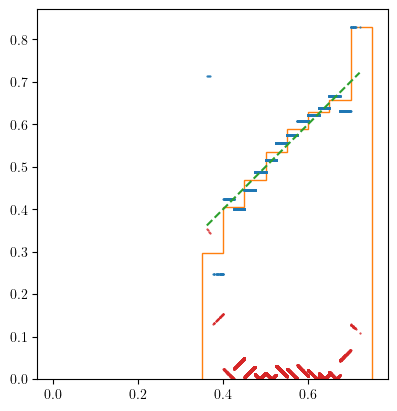

In [10]:
from fvt_classifier import kernel

random_idx = np.random.choice(len(events_tst_CR), size=2**14)
random_events = events_tst_CR[random_idx]
preds = CR_model_new.predict(random_events.X_torch.to(device))[:, 1]
K = kernel(preds, preds, CR_model_new.calibration_h, kernel_type="bins")
K = K * random_events.weights.reshape(1, -1)  # is this correct?
K = K / K.sum(dim=1, keepdim=True)
acc = (K @ random_events.is_4b_torch.to(torch.float32).reshape(-1, 1)).reshape(-1)
acc = acc.detach().cpu().numpy()
preds = preds.detach().cpu().numpy()


nbins = 20
bins = np.linspace(0, 1, nbins + 1)
bin_idx = np.digitize(preds, bins)
bin_idx = np.clip(bin_idx, 1, nbins - 1) - 1
acc_by_bin = np.zeros(nbins)
for i in range(nbins):
    acc_by_bin[i] = (random_events.is_4b * random_events.weights)[bin_idx == i].sum() / random_events.weights[bin_idx == i].sum()

plt.figure()
plt.plot(preds, acc, ".", markersize=1)
plt.stairs(acc_by_bin, bins, fill=False)
plt.plot((np.min(preds), np.max(preds)), (np.min(preds), np.max(preds)), "--")
plt.plot(preds, np.abs(acc - preds), ".", markersize=1)
plt.gca().set_aspect("equal")
plt.show()
plt.close()



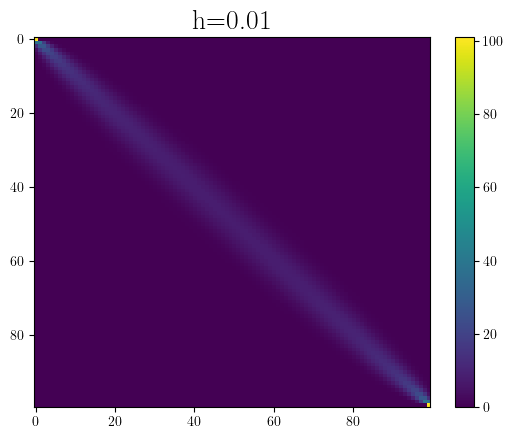

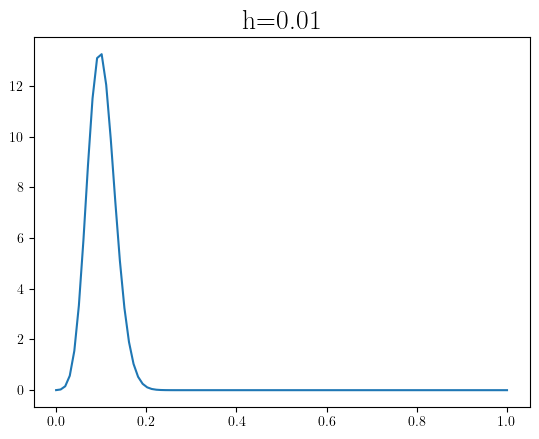

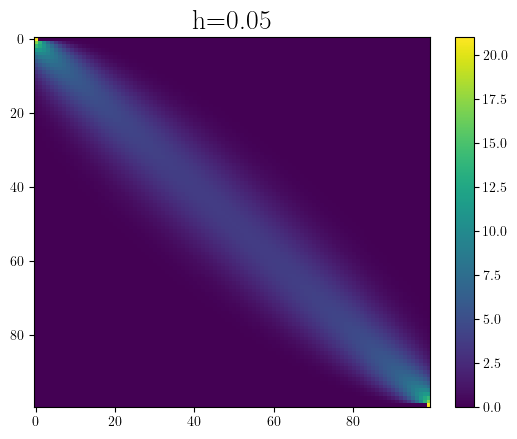

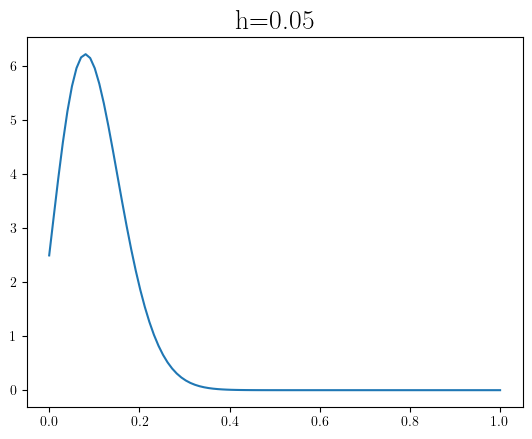

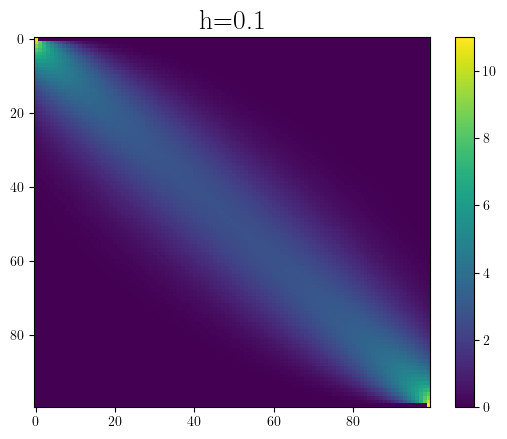

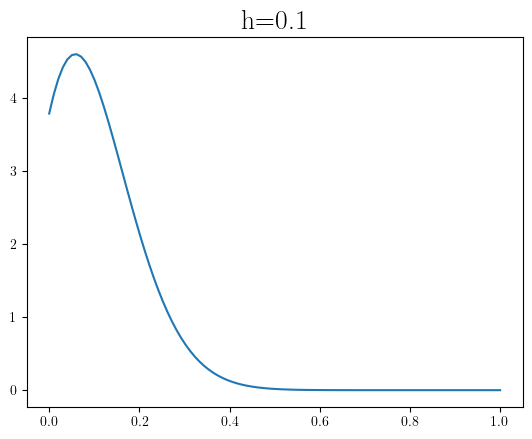

In [26]:
nbins = 100
x = torch.linspace(0, 1, nbins)
y = torch.linspace(0, 1, nbins)
for h in [0.01, 0.05, 0.1]:
    kernel_matrix = kernel(x, y, h=h, kernel_type="dirichlet").detach().cpu().numpy()
    plt.figure()
    plt.title(f"h={h}")
    plt.imshow(kernel_matrix, aspect="auto")
    plt.colorbar()
    plt.show()
    plt.close()
    
    plt.figure()
    plt.title(f"h={h}")
    plt.plot(x, kernel_matrix[nbins//10])
    plt.show()
    plt.close()